<a href="https://colab.research.google.com/github/hirotakaster/imagesearch/blob/main/nns_ngt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NGTのインストール
NGTはGPUを利用しないが、PyTorchでGPUを利用するため、ランタイムの設定でGPUを有効にしておく。

In [1]:
# PyTorchのインストール
!pip install torchinfo

# NGTのインストール
!wget https://github.com/yahoojapan/NGT/archive/refs/tags/v1.13.8.tar.gz
!tar -zxvf v1.13.8.tar.gz
%cd NGT-1.13.8/
%mkdir build
%cd build
!apt install cmake
!cmake ..
!make
!make install
!pip3 install ngt

# 画像データ類の取得
!git clone https://github.com/hirotakaster/imagesearch

--2022-01-11 01:31:37--  https://github.com/yahoojapan/NGT/archive/refs/tags/v1.13.8.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/yahoojapan/NGT/tar.gz/refs/tags/v1.13.8 [following]
--2022-01-11 01:31:37--  https://codeload.github.com/yahoojapan/NGT/tar.gz/refs/tags/v1.13.8
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.13.8.tar.gz.1’

v1.13.8.tar.gz.1        [      <=>           ]   1.99M  1.74MB/s    in 1.1s    

2022-01-11 01:31:41 (1.74 MB/s) - ‘v1.13.8.tar.gz.1’ saved [2088550]

NGT-1.13.8/
NGT-1.13.8/.gitignore
NGT-1.13.8/CMakeLists.txt
NGT-1.13.8/LICENSE
NGT-1.13.8/README-jp.md
NGT-1.13.8/README.jp
NGT-1

In [2]:
# 画像表示用
import cv2
import matplotlib.pyplot as plt

def show_image_files(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, f in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))

# 特徴量を取得するPytorchのモデル準備
・最後の結合層を除去して特徴量として利用する

In [3]:
import torch
import matplotlib.pyplot as plt
import glob
import cv2
import os
from torchvision import transforms
from PIL import Image
from IPython.display import display
from torchinfo import summary

# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
pointmodel = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
pointmodel.eval()
print(summary(pointmodel, input_size=(2, 3, 224, 224)))

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [2, 256, 56, 56]          16,384
│    │    └─BatchNorm2d: 3-2             [2, 256, 56, 56]          512
│    │    └─ReLU: 3-3                    [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-4                  [2, 256, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-5             [2, 256, 56, 56]          512
│    │    └─ReLU: 3-6                    [2, 256, 56, 56]          --
│

# ■ 全結合層を差し替えて特徴ベクトルとして利用する

In [4]:
pointmodel.fc = torch.nn.Identity() 
pointmodel.eval()
print(summary(pointmodel, input_size=(2, 3, 224, 224)))

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [2, 256, 56, 56]          16,384
│    │    └─BatchNorm2d: 3-2             [2, 256, 56, 56]          512
│    │    └─ReLU: 3-3                    [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-4                  [2, 256, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-5             [2, 256, 56, 56]          512
│    │    └─ReLU: 3-6                    [2, 256, 56, 56]          --
│

# NGTのインデックス作成

In [5]:
import ngtpy

ngtpy.create(path=b'index', dimension=2048, distance_type="L2")
index = ngtpy.Index(b'index')

if torch.cuda.is_available():
    pointmodel.to('cuda')

files = glob.glob("imagesearch/data/train/*.jpeg")
for f in files:
  input_image = Image.open(f)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = pointmodel(input_batch)
  n = output.to('cpu').detach().numpy().copy()
  index.insert(n.reshape(-1, 2048)[0]) 

index.build_index()
index.save()


# NGTで画像探索

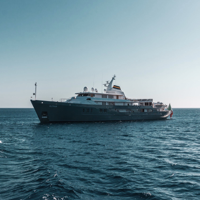

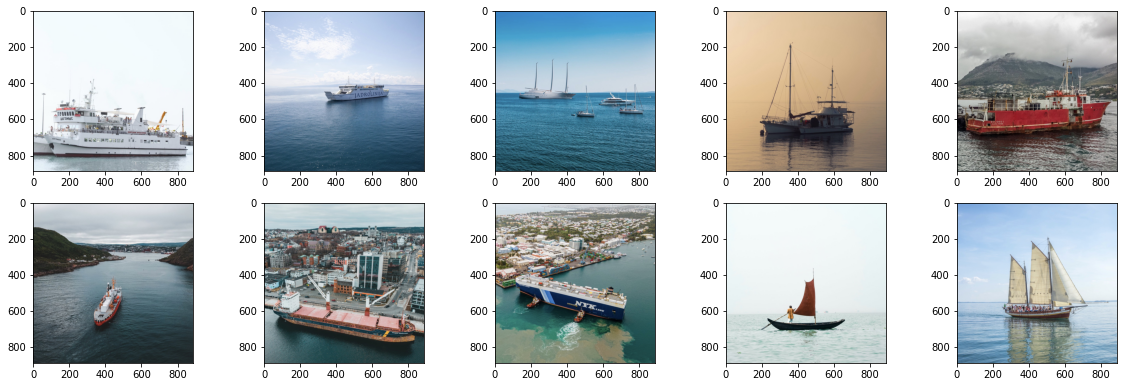

In [6]:
input_image = Image.open("imagesearch/data/test/004.jpeg")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
  output = pointmodel(input_batch)
n = output.to('cpu').detach().numpy().copy()

display(input_image.resize((200, 200)))

r = index.search(n.reshape(-1, 2048)[0], 10)
hitfiles = map(lambda f: files[f], [b[0] for b in r])
show_image_files(list(hitfiles))